In [81]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from keras.models import Sequential
from keras.layers import GRU, Dense, TimeDistributed
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import keras.backend as K
from keras.losses import categorical_crossentropy

# Chargement des données
data = pd.read_csv('turnips2.csv')

# Sélection des colonnes pertinentes (prix)
columns = ['Mon-AM', 'Mon-PM', 'Tues-AM', 'Tues-PM', 'Wed-AM', 'Wed-PM', 'Thurs-AM', 'Thurs-PM', 'Fri-AM', 'Fri-PM', 'Sat-AM', 'Sat-PM']

# Normalisation des données
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[columns])

# Clustering pour déterminer les labels
kmeans = KMeans(n_clusters=4, random_state=0)
labels = kmeans.fit_predict(data_scaled)

# Préparation des données pour le RNN
X = np.reshape(data_scaled, (data_scaled.shape[0], 12, 1))  # Remodelage en [échantillons, pas de temps, caractéristiques]
y = to_categorical(labels)  # Conversion des labels en format catégorique pour la classification

# Extension des étiquettes pour chaque pas de temps dans la séquence
y_expanded = np.repeat(y[:, np.newaxis, :], 12, axis=1)

# Split des données en ensembles d'entraînement et de test avec les étiquettes ajustées
X_train, X_test, y_train, y_test = train_test_split(X, y_expanded, test_size=0.2, random_state=42)

# Nombre de classes pour la classification
num_classes = 4  # Ajustez ce nombre en fonction de votre nombre de classes réel


def weighted_loss(a):
    def loss(y_true, y_pred):
        # Calcul de la perte catégorique croisée standard
        standard_loss = categorical_crossentropy(y_true, y_pred)
        
        # Calcul des poids pour chaque pas de temps dans la séquence
        # K.arange génère une séquence de 0 à nb_steps-1, où nb_steps est la taille de la séquence
        nb_steps = K.int_shape(y_pred)[1]
        timesteps = K.arange(nb_steps, dtype=K.floatx())
        weights = (a*timesteps)**2#1 - K.exp(-a * timesteps)  # 1-exp(-at) pour chaque pas de temps
        
        # Appliquer les poids à la perte
        weighted_loss = weights * standard_loss
        
        # Moyenne sur tous les pas de temps
        return K.mean(weighted_loss, axis=-1)
    
    return loss

def create_rnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(GRU(units=20, return_sequences=True, input_shape=input_shape))
    # Utilisez TimeDistributed pour appliquer une couche Dense à chaque sortie de séquence
    model.add(TimeDistributed(Dense(num_classes, activation='softmax')))
    model.compile(optimizer='adam', loss=weighted_loss(a=0.1), metrics=['accuracy'])
    return model

# Créez le modèle en spécifiant la forme d'entrée et le nombre de classes
model = create_rnn_model(input_shape=(12, 1), num_classes=num_classes)

# Entraînement du modèle
model.fit(X_train, y_train, epochs=1000, batch_size=256, verbose=1)

# Évaluation du modèle
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Epoch 1/1000
32/32 [==============================] - 1s 8ms/step - loss: 0.5773 - accuracy: 0.3074
Epoch 2/1000
32/32 [==============================] - 0s 6ms/step - loss: 0.5386 - accuracy: 0.3586
Epoch 3/1000
32/32 [==============================] - 0s 6ms/step - loss: 0.4857 - accuracy: 0.3514
Epoch 4/1000
32/32 [==============================] - 0s 6ms/step - loss: 0.4037 - accuracy: 0.4059
Epoch 5/1000
32/32 [==============================] - 0s 5ms/step - loss: 0.3496 - accuracy: 0.4176
Epoch 6/1000
32/32 [==============================] - 0s 5ms/step - loss: 0.3250 - accuracy: 0.4342
Epoch 7/1000
32/32 [==============================] - 0s 5ms/step - loss: 0.3066 - accuracy: 0.4541
Epoch 8/1000
32/32 [==============================] - 0s 5ms/step - loss: 0.2911 - accuracy: 0.4733
Epoch 9/1000
32/32 [==============================] - 0s 5ms/step - loss: 0.2757 - accuracy: 0.4908
Epoch 10/1000
32/32 [==============================] - 0s 5ms/step - loss: 0.2602 - accuracy: 0.5084

1/1 [==============================] - 0s 15ms/step


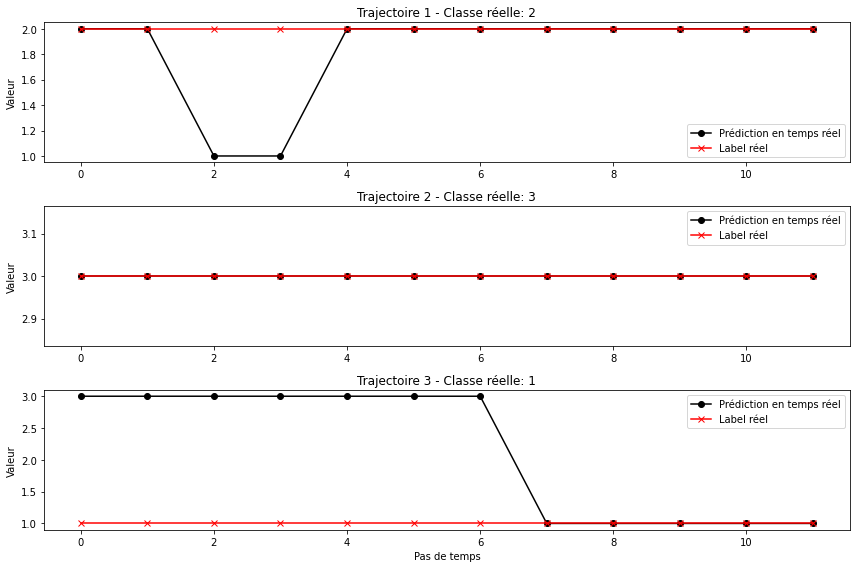

In [98]:
import matplotlib.pyplot as plt

# Sélection aléatoire de 3 indices d'échantillons dans l'ensemble de test
indices = np.random.choice(range(len(X_test)), 3, replace=False)

# Configuration des couleurs pour les graphiques
colors = ['red', 'green', 'blue']

plt.figure(figsize=(12, 8))

for i, idx in enumerate(indices):
    # Extraction de l'échantillon et de son étiquette réelle
    sample, true_label = X_test[idx], y_test[idx]
    sample = sample.reshape(1, 12, 1)  # Redimensionnement pour correspondre à l'entrée attendue du modèle
    true_label = np.argmax(true_label, axis=1)[0]
    # Prédiction avec le modèle RNN
    prediction = model.predict(sample)
    predicted_label = np.argmax(prediction, axis=2).reshape(12,)
    # Tracé de la trajectoire réelle
    plt.subplot(3, 1, i+1)
    plt.plot(predicted_label, label='Prédiction en temps réel', color='black', marker='o')
    plt.plot(true_label*np.ones(12), label='Label réel', color='red', marker='x')
    
    # Ajout du titre incluant la classe prédite
    plt.title(f'Trajectoire {i+1} - Classe réelle: {true_label}')
    plt.ylabel('Valeur')
    plt.legend()

plt.xlabel('Pas de temps')
plt.tight_layout()
plt.show()

## Entraînement du régresseur pour la première classe

In [102]:
from keras.models import Sequential
from keras.layers import GRU, RepeatVector, TimeDistributed, Dense

cluster_id = 0
cluster_indices = np.where(labels == cluster_id)[0]

# Préparer les ensembles de données pour ce cluster
X_cluster = data_scaled[cluster_indices, 0]  # Premier prix comme entrée
Y_cluster = data_scaled[cluster_indices, 1:]  # Les 11 prix suivants comme cibles

# Redimensionnement pour correspondre à l'entrée et sortie attendue du GRU
X_cluster = X_cluster.reshape(-1, 1, 1)  # (Nombre d'échantillons, Nombre de pas de temps, Nombre de caractéristiques)
Y_cluster = Y_cluster.reshape(-1, 11, 1)

# Split des données en ensembles d'entraînement et de test
X_train, X_test, Y_train, Y_test = train_test_split(X_cluster, Y_cluster, test_size=0.2, random_state=42, shuffle = False)

# Définition du modèle GRU
model0 = Sequential()
model0.add(GRU(5, input_shape=(1, 1)))
model0.add(RepeatVector(11))  # Répéter la sortie du GRU 11 fois
model0.add(GRU(5, return_sequences=True))
model0.add(TimeDistributed(Dense(1)))  # Prédire chaque prix des 11 prochains pas de temps
model0.compile(optimizer='adam', loss='mse')

# Entraînement du modèle
model0.fit(X_train, Y_train, epochs=1000, batch_size=512, verbose=1)

# Évaluation du modèle
loss = model0.evaluate(X_test, Y_test)
print(f'Cluster {cluster_id} Test Loss: {loss}')


Epoch 1/1000
3/3 [==============================] - 2s 8ms/step - loss: 1.5451
Epoch 2/1000
3/3 [==============================] - 0s 8ms/step - loss: 1.5388
Epoch 3/1000
3/3 [==============================] - 0s 9ms/step - loss: 1.5332
Epoch 4/1000
3/3 [==============================] - 0s 13ms/step - loss: 1.5285
Epoch 5/1000
3/3 [==============================] - 0s 9ms/step - loss: 1.5243
Epoch 6/1000
3/3 [==============================] - 0s 767us/step - loss: 1.5206
Epoch 7/1000
3/3 [==============================] - 0s 8ms/step - loss: 1.5172
Epoch 8/1000
3/3 [==============================] - 0s 12ms/step - loss: 1.5141
Epoch 9/1000
3/3 [==============================] - 0s 17ms/step - loss: 1.5115
Epoch 10/1000
3/3 [==============================] - 0s 15ms/step - loss: 1.5087
Epoch 11/1000
3/3 [==============================] - 0s 17ms/step - loss: 1.5062
Epoch 12/1000
3/3 [==============================] - 0s 3ms/step - loss: 1.5039
Epoch 13/1000
3/3 [=======================

In [ ]:
# Sélectionner aléatoirement trois échantillons de l'ensemble de test
indices = np.random.choice(X_test.shape[0], 3, replace=False)

# Configuration des graphiques
plt.figure(figsize=(15, 5))

for i, idx in enumerate(indices):
    # Obtenir le premier prix de l'échantillon
    first_price = X_test[idx].flatten()[0]  # Le premier prix est l'entrée du modèle

    # Prédiction des 11 prix suivants à partir du premier prix
    predicted_trajectory = model0.predict(X_test[idx:idx+1]).flatten()

    # Créer une trajectoire complète incluant le premier prix pour la trajectoire prédite
    complete_predicted_trajectory = np.insert(predicted_trajectory, 0, first_price)

    # Vraie trajectoire (les 11 prix suivants), avec le premier prix inclus
    true_trajectory = np.insert(Y_test[idx].flatten(), 0, first_price)

    # Tracer les vraies trajectoires et les trajectoires prédites
    plt.subplot(1, 3, i+1)
    plt.plot(range(12), true_trajectory, label='Vraie Trajectoire', color='red', marker='x')
    plt.plot(range(12), complete_predicted_trajectory, label='Trajectoire Prédite', color='black', marker='o')
    plt.title(f'Trajectoire {i+1}')
    plt.xlabel('Temps')
    plt.ylabel('Prix')
    plt.legend()

plt.tight_layout()
plt.show()

## Entraînement du régresseur pour la deuxième classe

In [124]:
cluster_id = 1
cluster_indices = np.where(labels == cluster_id)[0]

# Préparer les ensembles de données pour ce cluster
X_cluster = data_scaled[cluster_indices, 0]  # Premier prix comme entrée
Y_cluster = data_scaled[cluster_indices, 1:]  # Les 11 prix suivants comme cibles

# Redimensionnement pour correspondre à l'entrée et sortie attendue du GRU
X_cluster = X_cluster.reshape(-1, 1, 1)  # (Nombre d'échantillons, Nombre de pas de temps, Nombre de caractéristiques)
Y_cluster = Y_cluster.reshape(-1, 11, 1)

# Split des données en ensembles d'entraînement et de test
X_train, X_test, Y_train, Y_test = train_test_split(X_cluster, Y_cluster, test_size=0.2, random_state=42, shuffle = False)

# Définition du modèle GRU
model1 = Sequential()
model1.add(GRU(5, input_shape=(1, 1)))
model1.add(RepeatVector(11))  # Répéter la sortie du GRU 11 fois
model1.add(GRU(5, return_sequences=True))
model1.add(TimeDistributed(Dense(1)))  # Prédire chaque prix des 11 prochains pas de temps
model1.compile(optimizer='adam', loss='mse')

# Entraînement du modèle
model1.fit(X_train, Y_train, epochs=1000, batch_size=512, verbose=1)

# Évaluation du modèle
loss = model1.evaluate(X_test, Y_test)
print(f'Cluster {cluster_id} Test Loss: {loss}')

Epoch 1/1000
4/4 [==============================] - 2s 9ms/step - loss: 1.5065
Epoch 2/1000
4/4 [==============================] - 0s 9ms/step - loss: 1.4969
Epoch 3/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.4880
Epoch 4/1000
4/4 [==============================] - 0s 9ms/step - loss: 1.4793
Epoch 5/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.4712
Epoch 6/1000
4/4 [==============================] - 0s 8ms/step - loss: 1.4632
Epoch 7/1000
4/4 [==============================] - 0s 6ms/step - loss: 1.4555
Epoch 8/1000
4/4 [==============================] - 0s 5ms/step - loss: 1.4480
Epoch 9/1000
4/4 [==============================] - 0s 6ms/step - loss: 1.4407
Epoch 10/1000
4/4 [==============================] - 0s 9ms/step - loss: 1.4335
Epoch 11/1000
4/4 [==============================] - 0s 9ms/step - loss: 1.4265
Epoch 12/1000
4/4 [==============================] - 0s 9ms/step - loss: 1.4193
Epoch 13/1000
4/4 [============================

1/1 [==============================] - 0s 18ms/step


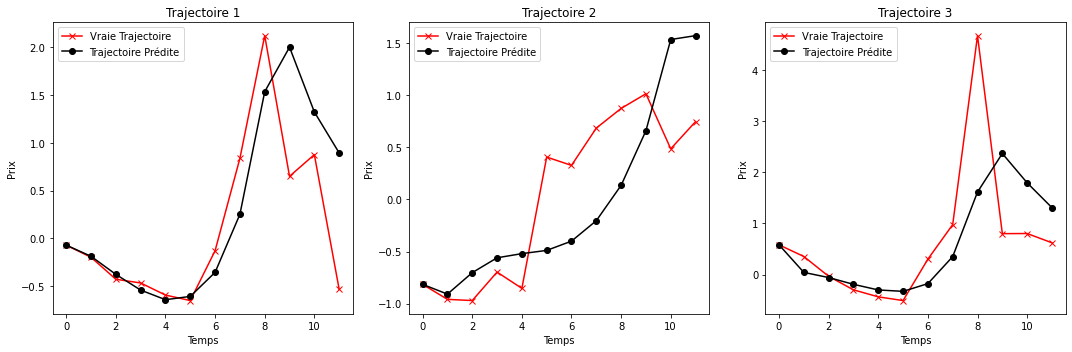

In [128]:
# Sélectionner aléatoirement trois échantillons de l'ensemble de test
indices = np.random.choice(X_test.shape[0], 3, replace=False)

# Configuration des graphiques
plt.figure(figsize=(15, 5))

for i, idx in enumerate(indices):
    # Obtenir le premier prix de l'échantillon
    first_price = X_test[idx].flatten()[0]  # Le premier prix est l'entrée du modèle

    # Prédiction des 11 prix suivants à partir du premier prix
    predicted_trajectory = model1.predict(X_test[idx:idx+1]).flatten()

    # Créer une trajectoire complète incluant le premier prix pour la trajectoire prédite
    complete_predicted_trajectory = np.insert(predicted_trajectory, 0, first_price)

    # Vraie trajectoire (les 11 prix suivants), avec le premier prix inclus
    true_trajectory = np.insert(Y_test[idx].flatten(), 0, first_price)

    # Tracer les vraies trajectoires et les trajectoires prédites
    plt.subplot(1, 3, i+1)
    plt.plot(range(12), true_trajectory, label='Vraie Trajectoire', color='red', marker='x')
    plt.plot(range(12), complete_predicted_trajectory, label='Trajectoire Prédite', color='black', marker='o')
    plt.title(f'Trajectoire {i+1}')
    plt.xlabel('Temps')
    plt.ylabel('Prix')
    plt.legend()

plt.tight_layout()
plt.show()

## Entraînement du régresseur pour la troisième classe

In [129]:
cluster_id = 2
cluster_indices = np.where(labels == cluster_id)[0]

# Préparer les ensembles de données pour ce cluster
X_cluster = data_scaled[cluster_indices, 0]  # Premier prix comme entrée
Y_cluster = data_scaled[cluster_indices, 1:]  # Les 11 prix suivants comme cibles

# Redimensionnement pour correspondre à l'entrée et sortie attendue du GRU
X_cluster = X_cluster.reshape(-1, 1, 1)  # (Nombre d'échantillons, Nombre de pas de temps, Nombre de caractéristiques)
Y_cluster = Y_cluster.reshape(-1, 11, 1)

# Split des données en ensembles d'entraînement et de test
X_train, X_test, Y_train, Y_test = train_test_split(X_cluster, Y_cluster, test_size=0.2, random_state=42, shuffle = False)

# Définition du modèle GRU
model2 = Sequential()
model2.add(GRU(5, input_shape=(1, 1)))
model2.add(RepeatVector(11))  # Répéter la sortie du GRU 11 fois
model2.add(GRU(5, return_sequences=True))
model2.add(TimeDistributed(Dense(1)))  # Prédire chaque prix des 11 prochains pas de temps
model2.compile(optimizer='adam', loss='mse')

# Entraînement du modèle
model2.fit(X_train, Y_train, epochs=1000, batch_size=512, verbose=1)

# Évaluation du modèle
loss = model2.evaluate(X_test, Y_test)
print(f'Cluster {cluster_id} Test Loss: {loss}')

Epoch 1/1000
5/5 [==============================] - 2s 8ms/step - loss: 0.9731
Epoch 2/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.9638
Epoch 3/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.9568
Epoch 4/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.9516
Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9474
Epoch 6/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.9441
Epoch 7/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.9412
Epoch 8/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.9386
Epoch 9/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9362
Epoch 10/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.9341
Epoch 11/1000
5/5 [==============================] - 0s 5ms/step - loss: 0.9323
Epoch 12/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9306
Epoch 13/1000
5/5 [=========================

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


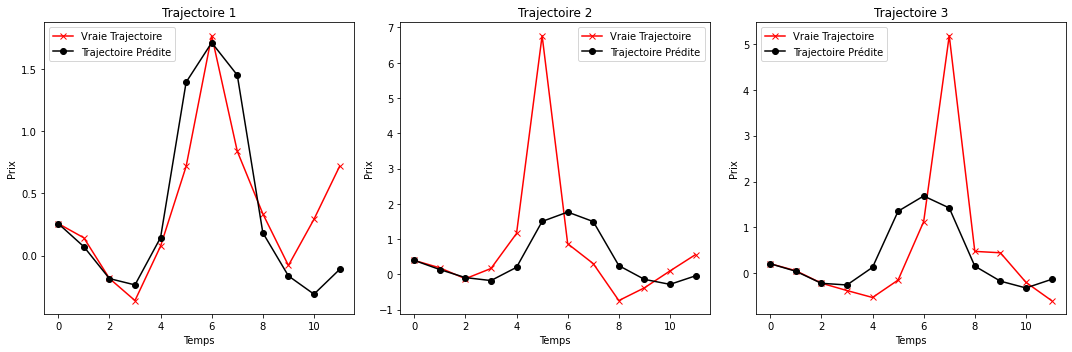

In [133]:
import matplotlib.pyplot as plt

# Sélectionner aléatoirement trois échantillons de l'ensemble de test
indices = np.random.choice(X_test.shape[0], 3, replace=False)

# Configuration des graphiques
plt.figure(figsize=(15, 5))

for i, idx in enumerate(indices):
    # Obtenir le premier prix de l'échantillon
    first_price = X_test[idx].flatten()[0]  # Le premier prix est l'entrée du modèle

    # Prédiction des 11 prix suivants à partir du premier prix
    predicted_trajectory = model2.predict(X_test[idx:idx+1]).flatten()

    # Créer une trajectoire complète incluant le premier prix pour la trajectoire prédite
    complete_predicted_trajectory = np.insert(predicted_trajectory, 0, first_price)

    # Vraie trajectoire (les 11 prix suivants), avec le premier prix inclus
    true_trajectory = np.insert(Y_test[idx].flatten(), 0, first_price)

    # Tracer les vraies trajectoires et les trajectoires prédites
    plt.subplot(1, 3, i+1)
    plt.plot(range(12), true_trajectory, label='Vraie Trajectoire', color='red', marker='x')
    plt.plot(range(12), complete_predicted_trajectory, label='Trajectoire Prédite', color='black', marker='o')
    plt.title(f'Trajectoire {i+1}')
    plt.xlabel('Temps')
    plt.ylabel('Prix')
    plt.legend()

plt.tight_layout()
plt.show()

## Entraînement du régresseur pour la quatrième classe

In [134]:
cluster_id = 3
cluster_indices = np.where(labels == cluster_id)[0]

# Préparer les ensembles de données pour ce cluster
X_cluster = data_scaled[cluster_indices, 0]  # Premier prix comme entrée
Y_cluster = data_scaled[cluster_indices, 1:]  # Les 11 prix suivants comme cibles

# Redimensionnement pour correspondre à l'entrée et sortie attendue du GRU
X_cluster = X_cluster.reshape(-1, 1, 1)  # (Nombre d'échantillons, Nombre de pas de temps, Nombre de caractéristiques)
Y_cluster = Y_cluster.reshape(-1, 11, 1)

# Split des données en ensembles d'entraînement et de test
X_train, X_test, Y_train, Y_test = train_test_split(X_cluster, Y_cluster, test_size=0.2, random_state=42, shuffle = False)

# Définition du modèle GRU
model3 = Sequential()
model3.add(GRU(5, input_shape=(1, 1)))
model3.add(RepeatVector(11))  # Répéter la sortie du GRU 11 fois
model3.add(GRU(5, return_sequences=True))
model3.add(TimeDistributed(Dense(1)))  # Prédire chaque prix des 11 prochains pas de temps
model3.compile(optimizer='adam', loss='mse')

# Entraînement du modèle
model3.fit(X_train, Y_train, epochs=1000, batch_size=512, verbose=1)

# Évaluation du modèle
loss = model3.evaluate(X_test, Y_test)
print(f'Cluster {cluster_id} Test Loss: {loss}')

Epoch 1/1000
6/6 [==============================] - 3s 13ms/step - loss: 0.4283
Epoch 2/1000
6/6 [==============================] - 0s 14ms/step - loss: 0.4047
Epoch 3/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.3855
Epoch 4/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.3698
Epoch 5/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.3554
Epoch 6/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.3431
Epoch 7/1000
6/6 [==============================] - 0s 15ms/step - loss: 0.3327
Epoch 8/1000
6/6 [==============================] - 0s 14ms/step - loss: 0.3243
Epoch 9/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.3171
Epoch 10/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.3113
Epoch 11/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3073
Epoch 12/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.3047
Epoch 13/1000
6/6 [===================

1/1 [==============================] - 0s 22ms/step


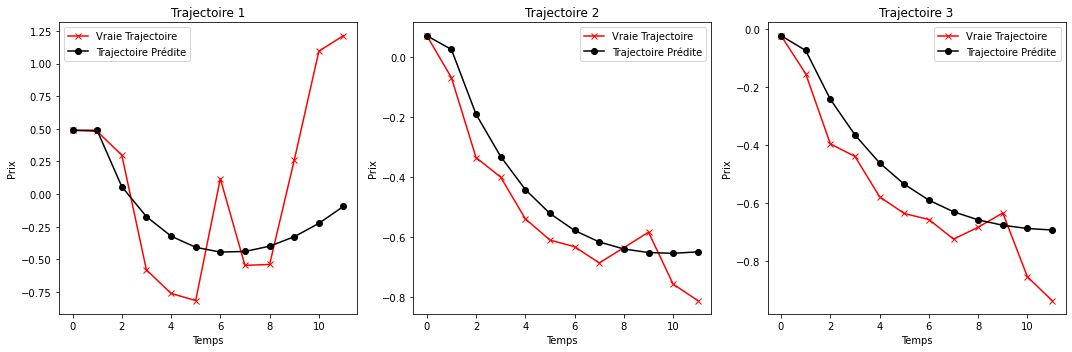

In [141]:
# Sélectionner aléatoirement trois échantillons de l'ensemble de test
indices = np.random.choice(X_test.shape[0], 3, replace=False)

# Configuration des graphiques
plt.figure(figsize=(15, 5))

for i, idx in enumerate(indices):
    # Obtenir le premier prix de l'échantillon
    first_price = X_test[idx].flatten()[0]  # Le premier prix est l'entrée du modèle

    # Prédiction des 11 prix suivants à partir du premier prix
    predicted_trajectory = model3.predict(X_test[idx:idx+1]).flatten()

    # Créer une trajectoire complète incluant le premier prix pour la trajectoire prédite
    complete_predicted_trajectory = np.insert(predicted_trajectory, 0, first_price)

    # Vraie trajectoire (les 11 prix suivants), avec le premier prix inclus
    true_trajectory = np.insert(Y_test[idx].flatten(), 0, first_price)

    # Tracer les vraies trajectoires et les trajectoires prédites
    plt.subplot(1, 3, i+1)
    plt.plot(range(12), true_trajectory, label='Vraie Trajectoire', color='red', marker='x')
    plt.plot(range(12), complete_predicted_trajectory, label='Trajectoire Prédite', color='black', marker='o')
    plt.title(f'Trajectoire {i+1}')
    plt.xlabel('Temps')
    plt.ylabel('Prix')
    plt.legend()

plt.tight_layout()
plt.show()